In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from __future__ import division
from scipy.signal import convolve2d
import torch

In [2]:
def getBorderColor(img):
    border = np.asarray(img[0,:])
    border = np.concatenate((border, np.asarray(img[-1, :])))
    border = np.concatenate((border, np.asarray(img[:, 0])))
    border = np.concatenate((border, np.asarray(img[:, -1])))
    return np.bincount(border).argmax()


def pre_processing(img):
    _, img_binarized = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)    
    if(getBorderColor(img_binarized) != 0):
        img_binarized = cv2.bitwise_not(img_binarized) 
    
    kernel = np.ones((30,30), np.uint8)
    img_dilation = cv2.dilate(img_binarized, kernel, iterations=1)
    cnts = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    cntsSorted = sorted(cnts, key=lambda x: cv2.contourArea(x), reverse=True)
    (x,y,w,h) = cv2.boundingRect(cntsSorted[0])
    return img_binarized[y:y+h, x:x+w]    

def showImage(img):
    plt.imshow(img, cmap='gray')
    plt.show()    

In [3]:
data_set = []
Y = []
for i in range(1, 10):
    for filename in os.listdir("ACdata_base/" + str(i)):
        img = cv2.imread(os.path.join("ACdata_base/" + str(i),filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            data_set.append(pre_processing(img))
            Y.append(i-1)

In [54]:
X_train, X_testValid, Y_train, Y_testValid = train_test_split(data_set, Y, test_size=0.4, random_state=13)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_testValid, Y_testValid, test_size=0.5, random_state=38)            

In [57]:
# unique, counts = np.unique(np.array(Y_train), return_counts=True)
# print(counts)
# unique, counts1 = np.unique(np.array(Y_validation), return_counts=True)
# print(counts1)
# unique, counts2 = np.unique(np.array(Y_test), return_counts=True)
# print(counts2)


In [58]:

def lpq(img, winSize=3, freqestim=1, mode='nh'):
    
    rho=0.90

    STFTalpha=1/winSize  # alpha in STFT approaches (for Gaussian derivative alpha=1)
    sigmaS=(winSize-1)/4 # Sigma for STFT Gaussian window (applied if freqestim==2)
    sigmaA=8/(winSize-1) # Sigma for Gaussian derivative quadrature filters (applied if freqestim==3)

    convmode='valid' # Compute descriptor responses only on part that have full neigborhood. Use 'same' if all pixels are included (extrapolates np.image with zeros).

    img=np.float64(img) # Convert np.image to double
    r=(winSize-1)/2 # Get radius from window size
    x=np.arange(-r,r+1)[np.newaxis] # Form spatial coordinates in window

    if freqestim==1:  #  STFT uniform window
        #  Basic STFT filters
        w0=np.ones_like(x)
        w1=np.exp(-2*np.pi*x*STFTalpha*1j)
        w2=np.conj(w1)

    ## Run filters to compute the frequency response in the four points. Store np.real and np.imaginary parts separately
    # Run first filter
    filterResp1=convolve2d(convolve2d(img,w0.T,convmode),w1,convmode)
    filterResp2=convolve2d(convolve2d(img,w1.T,convmode),w0,convmode)
    filterResp3=convolve2d(convolve2d(img,w1.T,convmode),w1,convmode)
    filterResp4=convolve2d(convolve2d(img,w1.T,convmode),w2,convmode)

    # Initilize frequency domain matrix for four frequency coordinates (np.real and np.imaginary parts for each frequency).
    freqResp=np.dstack([filterResp1.real, filterResp1.imag,
                        filterResp2.real, filterResp2.imag,
                        filterResp3.real, filterResp3.imag,
                        filterResp4.real, filterResp4.imag])

    ## Perform quantization and compute LPQ codewords
    inds = np.arange(freqResp.shape[2])[np.newaxis,np.newaxis,:]
    LPQdesc=((freqResp>0)*(2**inds)).sum(2)

    ## Switch format to uint8 if LPQ code np.image is required as output
    if mode=='im':
        LPQdesc=np.uint8(LPQdesc)

    ## Histogram if needed
    if mode=='nh' or mode=='h':
        LPQdesc=np.histogram(LPQdesc.flatten(),range(256))[0]

    ## Normalize histogram if needed
    if mode=='nh':
        LPQdesc=LPQdesc/LPQdesc.sum()
    
    return LPQdesc

In [59]:
def getFeatures(img):
    return lpq(img)

def getFeaturesList(images):
   features = []
   for i in range(len(images)):
        features.append(getFeatures(images[i]))
   return np.asarray(features)    

In [61]:
train_features = getFeaturesList(X_train)
validation_features = getFeaturesList(X_validation)
test_features = getFeaturesList(X_test)

print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

(1011, 255)
(337, 255)
(337, 255)


In [62]:
# H is hidden dimension; D_out is output dimension.
N, D_in, H1, D_out = train_features.shape[0], train_features.shape[1], 128, 9

x = torch.tensor(train_features).double()
y = torch.tensor(Y_train)

x_validation = torch.tensor(validation_features).double()
Y_validation = torch.tensor(Y_validation)

x_test = torch.tensor(test_features).double()
y_test = torch.tensor(Y_test)

In [80]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, D_out),
    torch.nn.LogSoftmax(dim=1)
)

loss_fn = torch.nn.NLLLoss()

learning_rate = 1.5*1e-4

model.to(device)
model.double()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
validation_losses = []

In [81]:
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

for t in range(35000):
    #print(t)
    x = x.to(device)
    y = y.to(device)
    
    y_pred = model(x)

    loss = loss_fn(y_pred, y)
    if t % 500 == 499:
        print(t+1, loss.item(),"  [Training]")
        training_losses.append(loss.item())
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 500 == 499:
        with torch.no_grad():
            x_valid = x_validation.to(device)
            y_valid = Y_validation.to(device)
            y_pred2 = model(x_valid)
            loss = loss_fn(y_pred2, y_valid)
            print(t+1, loss.item(),"  [Validation]" )
            validation_losses.append(loss.item())


500 2.032137221284685   [Training]
500 2.035113367518738   [Validation]
1000 1.7733881125065674   [Training]
1000 1.7748406509064585   [Validation]
1500 1.5899066470247019   [Training]
1500 1.5878907274563796   [Validation]
2000 1.458968692487876   [Training]
2000 1.454945858063632   [Validation]
2500 1.3550756423093144   [Training]
2500 1.3502015312783253   [Validation]
3000 1.2670020615543673   [Training]
3000 1.2621253119757057   [Validation]
3500 1.189940534376656   [Training]
3500 1.1857889522977343   [Validation]
4000 1.1211299805714086   [Training]
4000 1.1184259530357166   [Validation]
4500 1.0578932246502124   [Training]
4500 1.057485697744881   [Validation]
5000 0.9975122163471488   [Training]
5000 1.000064070779082   [Validation]
5500 0.9382102677326136   [Training]
5500 0.943829728217261   [Validation]
6000 0.8792773347489127   [Training]
6000 0.8882487142433969   [Validation]
6500 0.8212738260513611   [Training]
6500 0.8339757237766461   [Validation]
7000 0.765450041833285

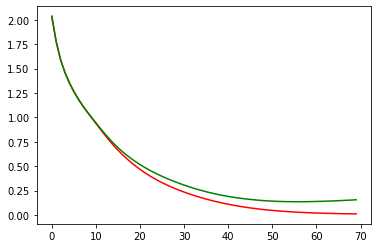

In [82]:
plt.plot(training_losses, '-r')
plt.plot(validation_losses, '-g')
plt.show()         

In [83]:
with torch.no_grad():
    y_pred = model(x)
    y_pred = torch.argmax(torch.exp(y_pred), dim=1)
    acc = (torch.sum(y_pred==y).item() / len(y)) * 100
    print("Training Accuracy = ", acc, "%")    

    x_valid = x_validation.to(device)
    y_valid = Y_validation.to(device)
    y_pred = model(x_valid)
    y_pred = torch.argmax(torch.exp(y_pred), dim=1)
    acc = (torch.sum(y_pred==y_valid).item() / len(y_valid)) * 100
    print("Validation Accuracy = ", acc, "%")

    x_test = x_test.to(device)
    y_test = y_test.to(device)

    y_pred = model(x_test)
    y_pred = torch.argmax(torch.exp(y_pred), dim=1)
    acc = (torch.sum(y_pred==y_test).item() / len(y_test)) * 100
    print("Test Accuracy = ", acc, "%")

Training Accuracy =  99.90108803165182 %
Validation Accuracy =  97.03264094955489 %
Test Accuracy =  98.81305637982196 %
